In [1]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import os
from subprocess import call
import seaborn as sns
from matplotlib import pyplot as plt

### Creare fasta file

In [2]:
fin = open('../data/external/kallisto/homo_sapiens/Homo_sapiens.GRCh38.cdna.all.fa')
flines = fin.readlines()
fin.close()

In [5]:
fout = open('../data/external/kallisto/homo_sapiens_ercc.fa', 'w')
for line in flines:
    fout.write(line)
fin = open('../data/external/ERCC92/ERCC92.fa', 'r')
flines = fin.readlines()
fin.close()
for line in flines:
    fout.write(line)
fout.close()

### Indexing

In [6]:
!kallisto index -i ../data/external/kallisto/transcripts.idx ../data/external/kallisto/homo_sapiens_ercc.fa


[build] loading fasta file ../data/external/kallisto/homo_sapiens_ercc.fa
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 1522 target sequences
[build] warning: replaced 6 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 1131979 contigs and contains 109622116 k-mers 



### Pseudo alignment

In [13]:
fnames = os.listdir('../data/spike-in-2/data/')
fnames.remove('.DS_Store')
sufix = '_sequence.txt.gz'
fnames = [x[:-len(sufix)-1] for x in fnames]
fnames = list(set(fnames))

In [14]:
fnames

['JVVKR_PolyA-1_21s004254-1-1_Du_lane121s004254_',
 'JVVKR_PolyA-5_21s004258-1-1_Du_lane121s004258_',
 'JVVKR_Combi-5_21s004253-1-1_Du_lane121s004253_',
 'JVVKR_Combi-4_21s004252-1-1_Du_lane121s004252_',
 'JVVKR_PolyA-3_21s004256-1-1_Du_lane121s004256_',
 'JVVKR_Combi-3_21s004251-1-1_Du_lane121s004251_']

In [15]:
for fname_ in fnames:
    os.mkdir('../results/ercc-2/' + fname_[:-1])

In [22]:
for fname_ in fnames:
    print(fname_)
    call(['kallisto', 'quant', 
          '-i', '../data/external/kallisto/transcripts.idx',
          '-o', '../results/ercc-2/'+fname_[:-1],
          '../data/spike-in-2/data/'+fname_+'1'+sufix, 
          '../data/spike-in-2/data/'+fname_+'2'+sufix])

JVVKR_PolyA-1_21s004254-1-1_Du_lane121s004254_
JVVKR_PolyA-5_21s004258-1-1_Du_lane121s004258_
JVVKR_Combi-5_21s004253-1-1_Du_lane121s004253_
JVVKR_Combi-4_21s004252-1-1_Du_lane121s004252_
JVVKR_PolyA-3_21s004256-1-1_Du_lane121s004256_
JVVKR_Combi-3_21s004251-1-1_Du_lane121s004251_


### Analysis

In [23]:
temp = pd.read_csv('../results/ercc-2/JVVKR_Combi-3_21s004251-1-1_Du_lane121s004251//abundance.tsv', 
                   sep='\t', header=0, index_col=0)
results = pd.DataFrame(index=temp.index, columns=[x[:-1] for x in fnames])
for fname_ in fnames:
    temp = pd.read_csv('../results/ercc-2/%s/abundance.tsv' % fname_[:-1], sep='\t', header=0, index_col=0)
    results[fname_[:-1]] = temp['tpm'].values

In [40]:
results.loc[ercc.index].sum()

JVVKR_PolyA-1_21s004254-1-1_Du_lane121s004254    11289.292906
JVVKR_PolyA-5_21s004258-1-1_Du_lane121s004258    13057.319700
JVVKR_Combi-5_21s004253-1-1_Du_lane121s004253    14451.022254
JVVKR_Combi-4_21s004252-1-1_Du_lane121s004252    14419.274921
JVVKR_PolyA-3_21s004256-1-1_Du_lane121s004256     9101.960849
JVVKR_Combi-3_21s004251-1-1_Du_lane121s004251    16963.877926
dtype: float64

In [27]:
ercc = pd.read_csv('../data/external/cms_095046.txt',
                  sep='\t', header=0, index_col=1)

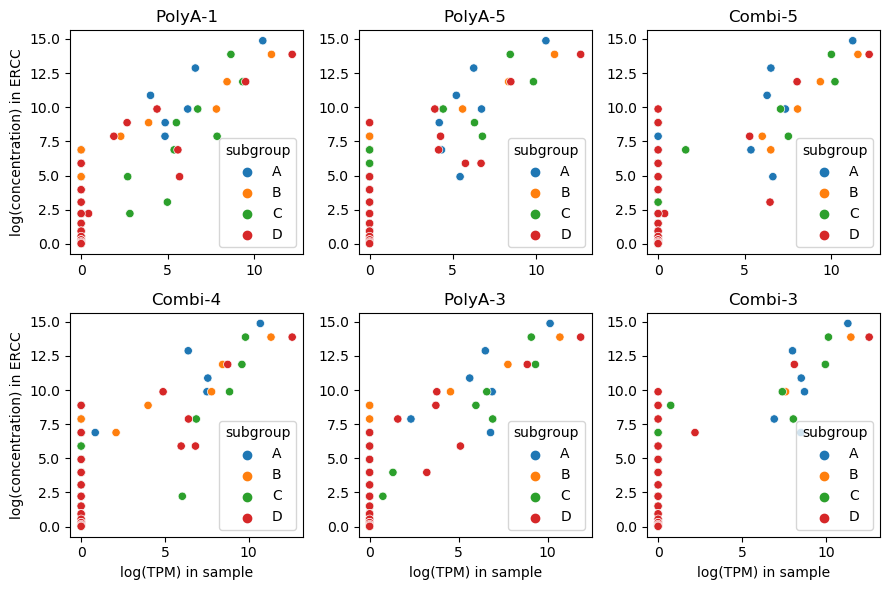

In [59]:
f, axs = plt.subplots(2, 3, figsize=(9, 6), dpi=100)
for i in range(6):
    j = i // 3
    k = i % 3
    x = results.loc[ercc.index][results.columns[i]]
    y = ercc['concentration in Mix 1 (attomoles/ul)']
    sns.scatterplot(x=np.log2(x+1),y=np.log2(y+1), hue=ercc['subgroup'], ax=axs[j,k])
    axs[j, k].set_xlabel('')
    axs[j, k].set_ylabel('')
    axs[j, k].set_title(results.columns[i].split('_')[1])
axs[0, 0].set_ylabel('log(concentration) in ERCC')
axs[1, 0].set_ylabel('log(concentration) in ERCC')
axs[1, 0].set_xlabel('log(TPM) in sample')
axs[1, 1].set_xlabel('log(TPM) in sample')
axs[1, 2].set_xlabel('log(TPM) in sample')
plt.tight_layout()
plt.savefig('../figures/temp/errc-20211222.png')